In [ ]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting
cuda

False

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [ ]:
adversarial_loss = torch.nn.BCELoss()

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
discriminator


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

print(count_parameters(generator))
print(count_parameters(discriminator))

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  model.0.weight |   12800    |
|   model.0.bias  |    128     |
|  model.2.weight |   32768    |
|   model.2.bias  |    256     |
|  model.3.weight |    256     |
|   model.3.bias  |    256     |
|  model.5.weight |   131072   |
|   model.5.bias  |    512     |
|  model.6.weight |    512     |
|   model.6.bias  |    512     |
|  model.8.weight |   524288   |
|   model.8.bias  |    1024    |
|  model.9.weight |    1024    |
|   model.9.bias  |    1024    |
| model.11.weight |   802816   |
|  model.11.bias  |    784     |
+-----------------+------------+
Total Trainable Params: 1510032
1510032
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| model.0.weight |   401408   |
|  model.0.bias  |    512     |
| model.2.weight |   131072   |
|  model.2.bias  |    256     |
| model.4.weight |    256     |
|  model.4.bias  |     1      |
+-----------

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [ ]:
temp_img.size()

torch.Size([1, 28, 28])

In [ ]:
28 // 4

7

In [ ]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

In [ ]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
# Visualize result
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



  0%|          | 0/235 [00:00<?, ?it/s]

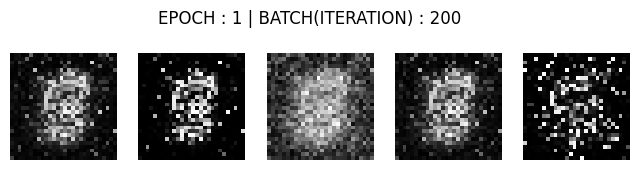

[Epoch: 1/25] [Batch: 235/235] [D loss: 0.485995] [G loss: 1.030833]


  0%|          | 0/235 [00:00<?, ?it/s]

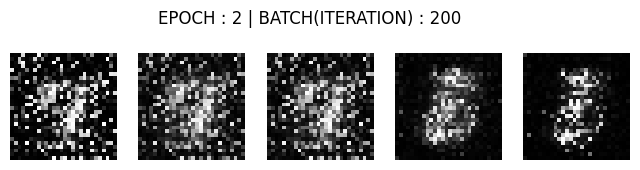

[Epoch: 2/25] [Batch: 235/235] [D loss: 0.449009] [G loss: 1.235800]


  0%|          | 0/235 [00:00<?, ?it/s]

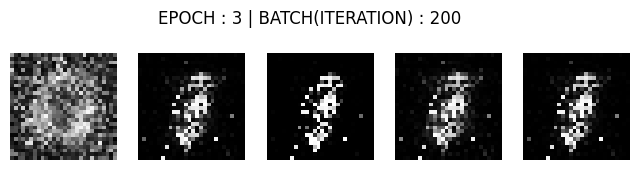

[Epoch: 3/25] [Batch: 235/235] [D loss: 0.548173] [G loss: 0.552994]


  0%|          | 0/235 [00:00<?, ?it/s]

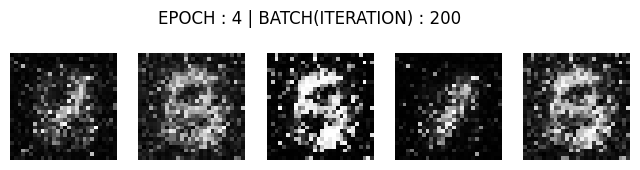

[Epoch: 4/25] [Batch: 235/235] [D loss: 0.485823] [G loss: 1.446721]


  0%|          | 0/235 [00:00<?, ?it/s]

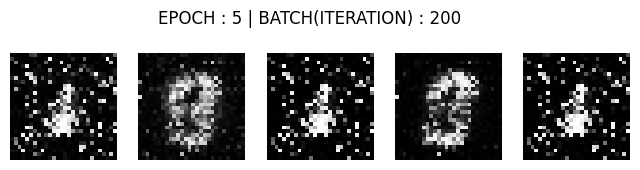

[Epoch: 5/25] [Batch: 235/235] [D loss: 0.408270] [G loss: 1.327981]


  0%|          | 0/235 [00:00<?, ?it/s]

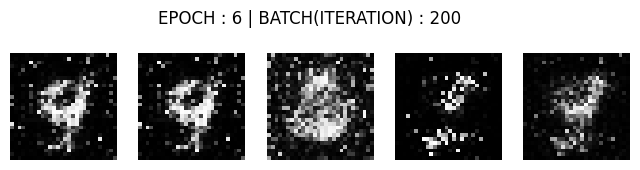

[Epoch: 6/25] [Batch: 235/235] [D loss: 0.371179] [G loss: 1.011045]


  0%|          | 0/235 [00:00<?, ?it/s]

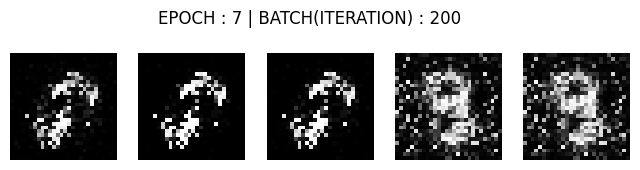

[Epoch: 7/25] [Batch: 235/235] [D loss: 0.777220] [G loss: 4.036507]


  0%|          | 0/235 [00:00<?, ?it/s]

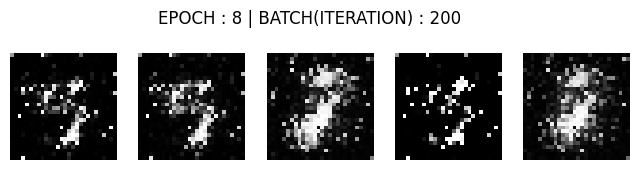

[Epoch: 8/25] [Batch: 235/235] [D loss: 0.382041] [G loss: 0.801114]


  0%|          | 0/235 [00:00<?, ?it/s]

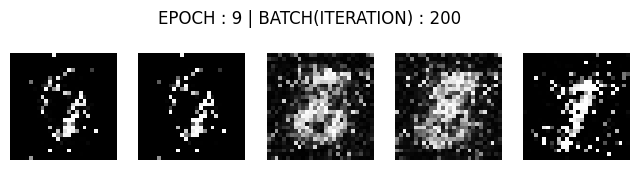

[Epoch: 9/25] [Batch: 235/235] [D loss: 0.441636] [G loss: 0.824619]


  0%|          | 0/235 [00:00<?, ?it/s]

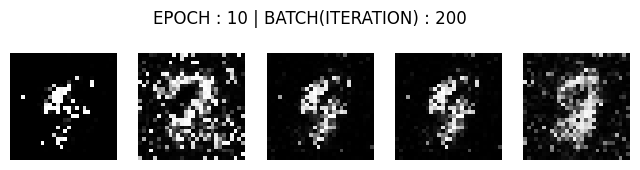

[Epoch: 10/25] [Batch: 235/235] [D loss: 0.608961] [G loss: 0.642363]


  0%|          | 0/235 [00:00<?, ?it/s]

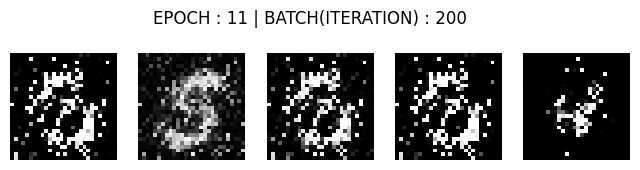

[Epoch: 11/25] [Batch: 235/235] [D loss: 0.193347] [G loss: 2.149411]


  0%|          | 0/235 [00:00<?, ?it/s]

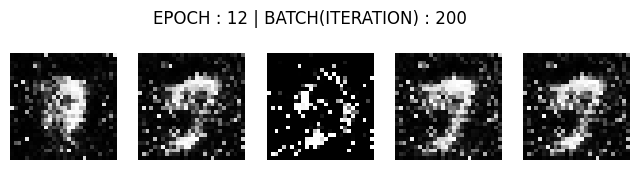

[Epoch: 12/25] [Batch: 235/235] [D loss: 0.454110] [G loss: 0.738756]


  0%|          | 0/235 [00:00<?, ?it/s]

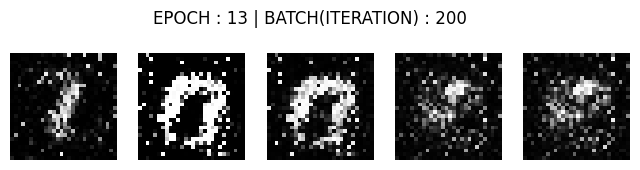

[Epoch: 13/25] [Batch: 235/235] [D loss: 0.273999] [G loss: 1.200177]


  0%|          | 0/235 [00:00<?, ?it/s]

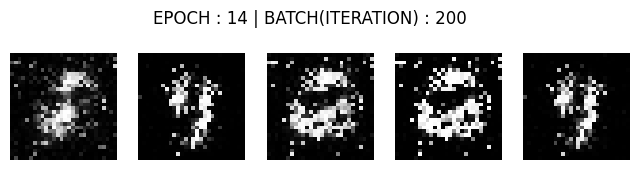

[Epoch: 14/25] [Batch: 235/235] [D loss: 0.335487] [G loss: 2.862529]


  0%|          | 0/235 [00:00<?, ?it/s]

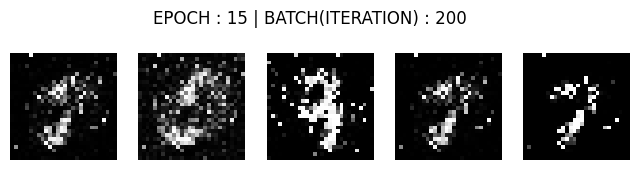

[Epoch: 15/25] [Batch: 235/235] [D loss: 0.222014] [G loss: 1.656847]


  0%|          | 0/235 [00:00<?, ?it/s]

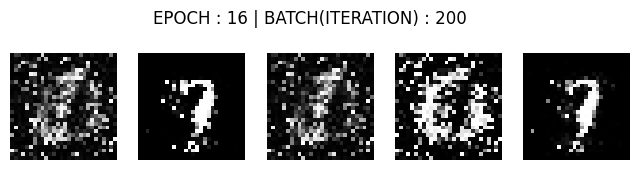

[Epoch: 16/25] [Batch: 235/235] [D loss: 0.292551] [G loss: 2.412512]


  0%|          | 0/235 [00:00<?, ?it/s]

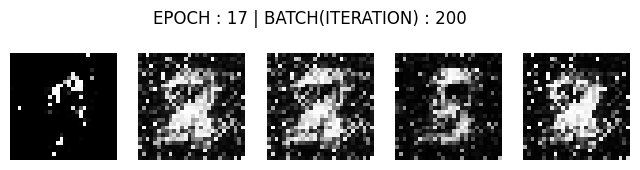

[Epoch: 17/25] [Batch: 235/235] [D loss: 0.264237] [G loss: 1.832408]


  0%|          | 0/235 [00:00<?, ?it/s]

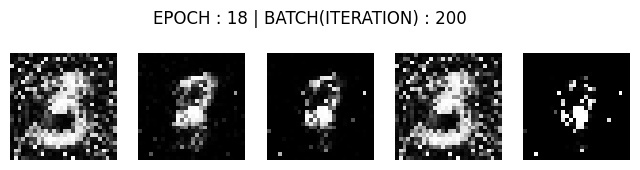

[Epoch: 18/25] [Batch: 235/235] [D loss: 0.344001] [G loss: 1.212853]


  0%|          | 0/235 [00:00<?, ?it/s]

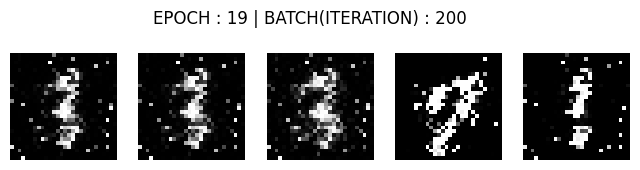

[Epoch: 19/25] [Batch: 235/235] [D loss: 0.357094] [G loss: 1.023042]


  0%|          | 0/235 [00:00<?, ?it/s]

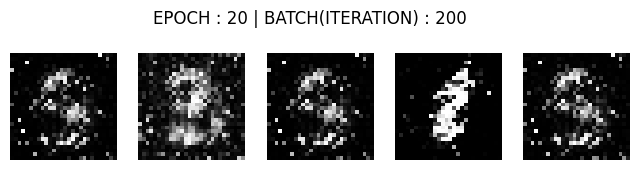

[Epoch: 20/25] [Batch: 235/235] [D loss: 0.219014] [G loss: 2.130017]


  0%|          | 0/235 [00:00<?, ?it/s]

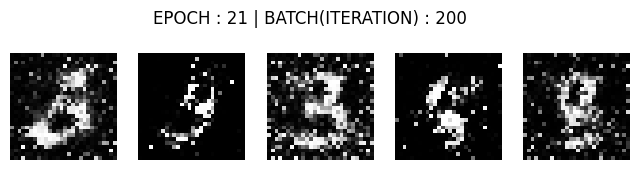

[Epoch: 21/25] [Batch: 235/235] [D loss: 0.245731] [G loss: 1.852616]


  0%|          | 0/235 [00:00<?, ?it/s]

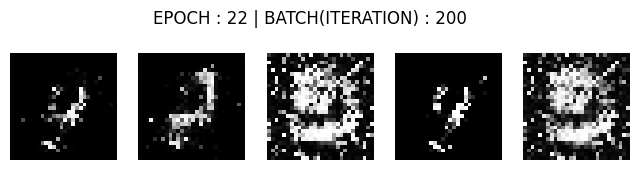

[Epoch: 22/25] [Batch: 235/235] [D loss: 0.594020] [G loss: 3.889291]


  0%|          | 0/235 [00:00<?, ?it/s]

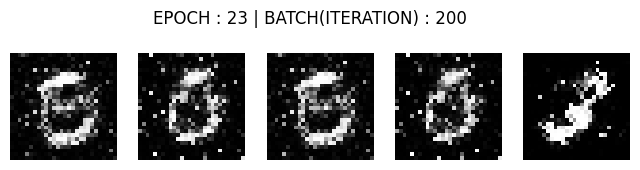

[Epoch: 23/25] [Batch: 235/235] [D loss: 0.752747] [G loss: 5.082590]


  0%|          | 0/235 [00:00<?, ?it/s]

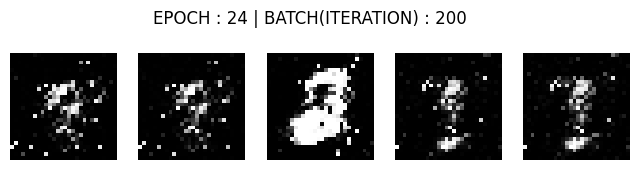

[Epoch: 24/25] [Batch: 235/235] [D loss: 0.197139] [G loss: 1.490197]


  0%|          | 0/235 [00:00<?, ?it/s]

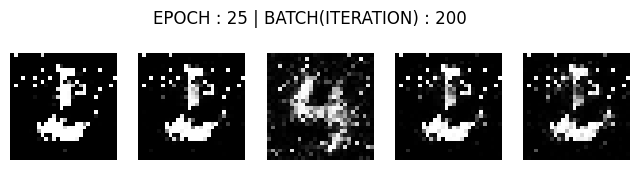

[Epoch: 25/25] [Batch: 235/235] [D loss: 0.187604] [G loss: 1.569128]


In [ ]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

In [ ]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape


torch.Size([64, 100])

In [ ]:
# generated images
sample_gen_imgs = generator(sample_z).detach().cpu()
sample_gen_imgs.shape


torch.Size([64, 1, 28, 28])

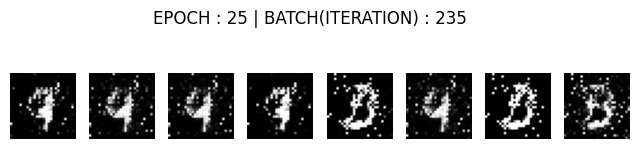

In [ ]:
nrow=1
ncols=8
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs.permute(0,2,3,1)[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

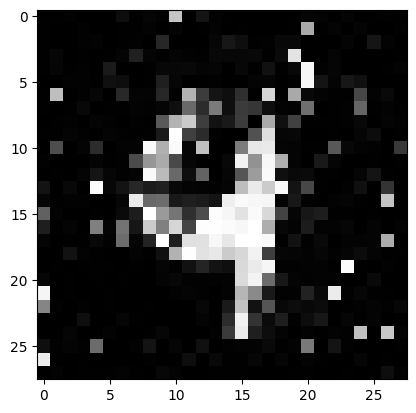

In [ ]:
show(sample_gen_imgs[1, :, :, :].detach())

In [ ]:
sample_gen_imgs[0, :, :, :].detach().shape

torch.Size([1, 28, 28])

In [ ]:
sample_gen_imgs

tensor([[[[-0.9963, -0.9916, -0.9959,  ..., -0.9988, -0.9971, -0.9953],
          [-0.9932, -0.9992, -0.9996,  ..., -0.9988, -0.9979, -0.9956],
          [-0.9932, -0.9993, -0.9976,  ..., -0.9900, -0.9956, -0.9984],
          ...,
          [-0.9870, -0.9951, -0.9867,  ..., -0.9981, -0.9993, -0.9959],
          [-0.6446, -0.9922, -0.9990,  ..., -0.9995, -0.9950, -0.9997],
          [-0.9976, -0.9942, -0.9988,  ..., -0.9819, -0.9991, -0.9965]]],


        [[[-0.9879, -0.9891, -0.9826,  ..., -0.9863, -0.9843, -0.9885],
          [-0.9854, -0.9961, -0.9976,  ..., -0.9948, -0.9965, -0.9837],
          [-0.9915, -0.9962, -0.9935,  ..., -0.8323, -0.9734, -0.9949],
          ...,
          [-0.8848, -0.9803, -0.9684,  ..., -0.9965, -0.9931, -0.9911],
          [ 0.8399, -0.9891, -0.9923,  ..., -0.9941, -0.9897, -0.9973],
          [-0.9922, -0.9712, -0.9963,  ..., -0.9908, -0.8860, -0.9836]]],


        [[[-0.9909, -0.9905, -0.9846,  ..., -0.9882, -0.9869, -0.9913],
          [-0.9872, -0.996